In [1]:
;cd "/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code/"

/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code


In [2]:
]activate learning_ds

In [3]:
]st

    Status `~/Dropbox/AAA_Bachir/Learning_with_side_information/Code/learning_ds/Project.toml`
  [336ed68f] CSV v0.5.12
  [a93c6f00] DataFrames v0.19.4
  [a077e3f3] DiffEqProblemLibrary v4.5.1
  [0c46a032] DifferentialEquations v6.7.0
  [7c1d4256] DynamicPolynomials v0.3.3
  [4076af6c] JuMP v0.20.0
  [6405355b] Mosek v1.0.4
  [1ec41992] MosekTools v0.9.0
  [3b7a836e] PGFPlots v3.1.3
  [8314cec4] PGFPlotsX v1.1.0
  [91a5bcdd] Plots v0.26.3
  [d330b81b] PyPlot v2.8.2
  [4b9e565b] SumOfSquares v0.3.5
  [c3572dad] Sundials v3.7.0


In [4]:
include("plotting_utilities.jl")
include("ode_helper.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots

Loaded diff equations


In [198]:
m = 1.
g = 9.81
ℓ = 1
α = g / ℓ

# vector field for the Elastic Pendulum
function Lagrangian(θ̇, θ)
    return 1/2 * θ̇^2 - α * (1 - cos(θ))
end

function vf(θ̇, θ)
    return [- α * sin(θ), θ̇]
end

x0 = [0, π/3]
θ̇, θ = solve_ode(vf, x0; verbose=true, tspan = (0., 30.0), length=100)

Solving ODE from x0=[0.0, 1.0472]
size(sol) = (2, 112)
length = 100


([0.0, -2.35113, -3.06191, -1.3874, 1.13486, 2.98265, 2.53507, 0.268079, -2.1496, -3.11172  …  2.73877, 2.81425, 0.772942, -1.71551, -3.10814, -2.05134, 0.379786, 2.5946, 2.92391, 1.01335], [1.0472, 0.673349, -0.210903, -0.929647, -0.96957, -0.30663, 0.596035, 1.04286, 0.744332, -0.113361  …  -0.479448, 0.429808, 1.00527, 0.855891, 0.0738173, -0.767103, -1.03274, -0.55748, 0.345063, 0.978538])

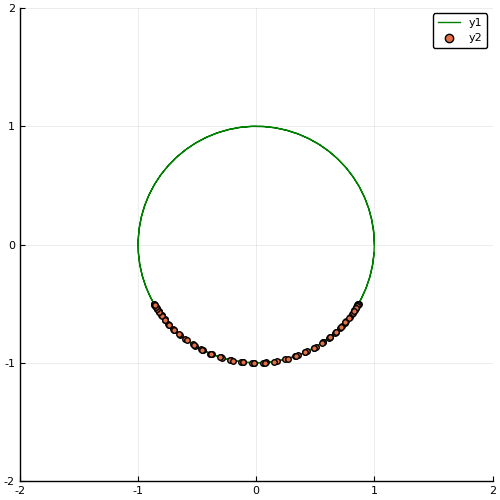

In [199]:
using Plots

function circle(x, y, r)
    Plots.plot!(r.*cos.(-2π:0.1:2π).+x, r.*sin.(-2π:0.1:2π).+y, color=:green)
end

function background() 
    #Plots.plot(x, y, color=:red, ls=:dot, lw=5, label="trajectory")
    Plots.plot()
    Plots.xlims!(-2, 2)
    Plots.ylims!(-2, 2)
    circle(0., 0., 1.)

end

x = sin.(θ)
y = -cos.(θ)
pyplot(size = (500,500))
background()
Plots.scatter!(x, y)
#axis("equal")

# Learn a polynomial lagrangian

<img src="polynomial_lagrangian.png">


In [201]:
# generate data
x0 = [0, π/3]
T = 10.
num_samples = 100
dT = T / num_samples
sample_trajectory = solve_ode(vf, x0; verbose=true, tspan = (0., T), length=num_samples)
θ̇_t, θ_t = sample_trajectory
size(θ_t), θ̇_t[1]

Solving ODE from x0=[0.0, 1.0472]
size(sol) = (2, 44)
length = 100


((100,), 0.0)

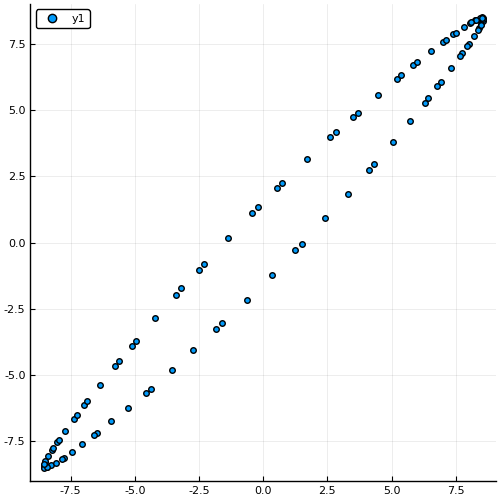

In [202]:
Plots.scatter( (θ̇_t[2:end] - θ̇_t[1:end-1]) ./ dT, -α * sin.(θ_t[2:end]))

In [203]:
@polyvar x y
# x => θ
# y => θ̇
θ̇  = y
θ = x 
model = SOSModel(with_optimizer(Mosek.Optimizer))
@variable model c[1:8]
@variable model γ
monomials = [θ̇^2, θ̇^3, θ, θ*θ̇^2, θ*θ̇^3 ,θ^2, θ^2*θ̇^2, θ^3]
lagrangian = monomials' * c


(c[7])x²y² + (c[5])xy³ + (c[8])x³ + (c[4])xy² + (c[2])y³ + (c[6])x² + (c[1])y² + (c[3])x

In [204]:
# Objective function coming from the Euler lagrange equation

lag_θ = differentiate(lagrangian, θ)
lag_θ̇ = differentiate(lagrangian, θ̇)

lag_θ_t = lag_θ.(θ̇_t, θ_t)
lag_θ̇_t = lag_θ̇.(θ̇_t, θ_t)

discrete_diff = v -> v[2:end] - v[1:end-1]

lag_θ̇_t_dt = discrete_diff(lag_θ̇_t) / dT

# Discard the last component so the size of lag_θ̇_t_dt
# and lag_θ_t matches
lag_θ_t = lag_θ_t[1:end-1] 
size(lag_θ_t), size(lag_θ̇_t_dt)


euler_lagrange = lag_θ̇_t_dt  - lag_θ_t
@constraint model [γ, euler_lagrange...] in SecondOrderCone()
0

0

In [205]:
@objective model Min γ
# normalization constraint
@constraint model sum(c) == 1
optimize!(model)
value(γ)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 101             
  Cones                  : 1               
  Scalar variables       : 109             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

0.1585241499221226

In [206]:
round(value(lagrangian), digits=4)

0.0001xy³ - 0.0804x³ - 0.0591xy² - 0.0349y³ + 0.0008x² + 0.0008y² + 1.1727x

In [207]:
round(value(lag_θ), digits=4)/round(value(lag_θ̇), digits=4)

(0.0001y³ - 0.2412x² - 0.0591y² + 0.0017x + 1.1727) / (0.0002xy² - 0.1182xy - 0.1048y² + 0.0016y)

In [208]:
lagrangian
@polyvar θ̈

lag_θ = differentiate(lagrangian, θ)
lag_θ̇ = differentiate(lagrangian, θ̇)
lag_θ̇_dt = θ̈ * differentiate(lag_θ̇, θ̇) + θ̇ * differentiate(lag_θ̇, θ)
euler_lagrange = value(lag_θ̇_dt - lag_θ)
euler_lagrange_eval(θv, θ̇v, θ̈v) = euler_lagrange(θ=>θv,θ̇=>θ̇v, θ̈=>θ̈v)
euler_lagrange_eval(θ, θ̇, θ̈)

-1.591318131036809e-5x²θ̈ - 1.591318131036809e-5xy² + 0.0003511342183200613xyθ̈ + 0.00011704473944002044y³ + 0.24116477750030826x² - 0.1182157683120677xθ̈ - 0.05910788415603385y² - 0.20950584237490952yθ̈ - 0.001688310904632867x + 0.0016208386096995728θ̈ - 1.1727086431546008

In [278]:
# hamiltonian (easy formula because L doesn't depend on time)
H = value(lagrangian - θ̇ * lag_θ̇)
cosθ = 1 - θ^2/2 + θ^4/24
H = 1/2 * θ̇^2 + α * (1 - cosθ)
true_H(θ̇, θ)  =  1/2 * θ̇^2 + α * (1 - cos(θ))


x0 = [0.1, π/10]
du₀ = [x0[1]]
u₀ = [x0[2]]

function f_dae(out, du, u, p, t)
    
    #out[1] = H(θ̇ => du[1], θ => u[1]) - H(θ̇ => du₀[1], θ => u₀[1]) 
    out[1] = true_H(du[1],u[1]) - H(du₀[1], u₀[1]) 
    @show du
end


tspan = (0, .1)
differential_vars = [true]
prob = DAEProblem(f_dae,du₀,u₀,tspan,differential_vars=differential_vars)
using Sundials
sol = Sundials.solve(prob, IDA())
using Plots; plotly() # Using the Plotly backend
Plots.plot(sol, tspan=tspan, layout=(3,1))

du = [0.1]
du = [0.1]
du = [3.25159]
du = [-0.130761]
du = [-0.36364]
du = [-0.630864]
du = [-0.977367]
du = [-1.49011]
du = [-2.38026]
du = [-4.29816]
du = [-10.037]
du = [-40.3172]
du = [-525.443]
du = [0.1]
du = [31.6159]
du = [0.0756099]
du = [0.0513548]
du = [0.0271968]
du = [0.00309867]
du = [-0.0209765]
du = [-0.0450652]
du = [-0.069204]
du = [-0.0934298]
du = [-0.11778]
du = [-0.142292]
du = [0.1]
du = [315.259]
du = [0.0975471]
du = [0.0950957]
du = [0.0926458]
du = [0.0901973]
du = [0.0877503]
du = [0.0853046]
du = [0.0828603]
du = [0.0804173]
du = [0.0779756]
du = [0.0755351]
du = [0.1]
du = [3151.69]
du = [0.0997546]
du = [0.0995091]
du = [0.0992637]
du = [0.0990184]
du = [0.098773]
du = [0.0985276]
du = [0.0982823]
du = [0.098037]
du = [0.0977917]
du = [0.0975464]
du = [0.1]
du = [31516.0]
du = [0.0999755]
du = [0.0999509]
du = [0.0999264]
du = [0.0999018]
du = [0.0998773]
du = [0.0998527]
du = [0.0998282]
du = [0.0998036]
du = [0.0997791]
du = [0.0997546]



[IDAS ERROR]  IDACalcIC
  Newton/Linesearch algorithm failed to converge.



BoundsError: BoundsError: attempt to access 1-element Array{Float64,1} at index [2]